In [2]:
import os
import shutil

import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from keras import Input
from keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    Concatenate,
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

2023-02-09 16:02:06.664890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 16:02:07.504666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-09 16:02:07.504765: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

2.11.0


In [3]:
#read data
data = pd.read_csv("./data/train.csv")
#shuffle data
data = data.sample(frac=1)

#print data
#data.head(10)
#data["keyword"].unique()

In [4]:
#one hot encode target
classes = [[0,1][source] for source in data.target]
target = to_categorical(classes)
#print target
target[10]

array([0., 1.], dtype=float32)

In [5]:
keywords = data.keyword.replace(np.NaN, '')

# data.keyword
# keywords = [keyword for keyword in data.keyword]
# keywords

In [6]:

preprocessing_keywordlayer = TextVectorization(
    output_sequence_length=2, 
    max_tokens=1000
    #, vocabulary = np.array(["Our","are", "in"])
)

# preprocessing_keywordlayer = TextVectorization(output_sequence_length = 1, max_tokens = 300)
preprocessing_keywordlayer.adapt(keywords) 
# preprocessing_layer.adapt(data.text)


2023-02-09 16:02:29.233285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:02:29.246660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:02:29.248528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:02:29.250734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
len(preprocessing_keywordlayer.get_vocabulary())

223

In [8]:
MAX_LEN = 22
MAX_TOKENS = 100000

preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, 
    max_tokens=MAX_TOKENS
    #, vocabulary = np.array(["Our","are", "in"])
)

In [9]:
preprocessing_layer.adapt(data.text)


In [10]:
preprocessing_layer(data.text[:10])

<tf.Tensor: shape=(10, 22), dtype=int64, numpy=
array([[   76,    97,     4,    82,  1051, 22435,  1160,    38,   594,
           11,  3537,   564, 15655, 16096,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  177,   986,   521,   857,     5,   513,   699,    26,   565,
          709,   178,   779,   196, 14267,   568,   153,     0,     0,
            0,     0,     0,     0],
       [ 1326,   292,  3759,  1944,    17,     2,   205,   844,     3,
          292,  1128,    71,  5083,     3,  5467,  6276,  2449, 17185,
            0,     0,     0,     0],
       [  178,   945,   558,     3,   768,   460,  1139,    17,   880,
         1760,  1213,    72,  1650,  1582,  6761,  1370,    14,   915,
          348,     0,     0,     0],
       [   98,    22,    11,    42,     7,    60,    24,    93,    10,
            3,   701,  1619,  8160,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  249,  1872,    10,  8446,  1737, 21705,   567, 

In [11]:
VOCAB_SIZE = len(preprocessing_layer.get_vocabulary())
VOCAB_SIZE

22699

In [34]:
inputs1 = Input(shape=(1,),dtype=tf.string, name="text")
inputs2 = Input(shape=(1,),dtype=tf.string, name="keywords")

x = preprocessing_layer(inputs1)
x = Embedding(VOCAB_SIZE+1,10,mask_zero=True)(x)
x = tf.keras.layers.BatchNormalization(axis=1)(x)
x = Lambda(lambda x:tf.reduce_mean(x,axis=1))(x)
x = Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = GRU(16)(x)


y= preprocessing_keywordlayer(inputs2)
y= Embedding(224,5,mask_zero=True)(y)
y= Flatten()(y)

outputs = Concatenate()([x,y])
outputs = Dense(1,activation="sigmoid")(outputs)
# outputs = Dense(2,activation="softmax")(x)

model = keras.Model(inputs=[inputs1,inputs2],outputs=outputs,name="modeltest")
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy",metrics=["Accuracy"])


Model: "modeltest"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 22)          0           ['text[0][0]']                   
 orization)                                                                                       
                                                                                                  
 embedding_8 (Embedding)        (None, 22, 10)       227000      ['text_vectorization_1[4][0]']   
                                                                                                  
 batch_normalization (BatchNorm  (None, 22, 10)      88          ['embedding_8[0][0]']    

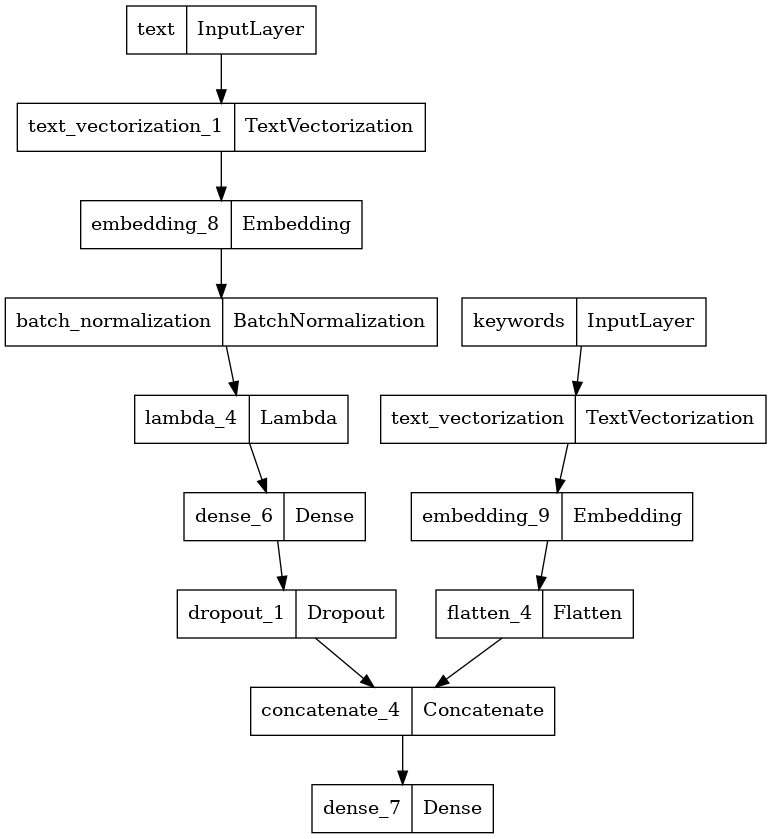

In [35]:
tf.keras.utils.plot_model(model)

In [36]:
modelhistory = model.fit(
    [data.text[:6000],keywords[:6000]],
    data.target[:6000], 
    epochs=50,
    batch_size=25, 
    validation_data=([data.text[6000:],keywords[6000:]],data.target[6000:]),
    callbacks=[EarlyStopping(patience=10)]
)

Epoch 1/50
240/240 [==============================] - 11s 38ms/step - loss: 0.5914 - Accuracy: 0.6918 - val_loss: 0.6182 - val_Accuracy: 0.7954
Epoch 2/50
240/240 [==============================] - 2s 10ms/step - loss: 0.3393 - Accuracy: 0.8737 - val_loss: 0.4751 - val_Accuracy: 0.7929
Epoch 3/50
240/240 [==============================] - 2s 8ms/step - loss: 0.1753 - Accuracy: 0.9385 - val_loss: 0.5638 - val_Accuracy: 0.7458
Epoch 4/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0902 - Accuracy: 0.9705 - val_loss: 0.6999 - val_Accuracy: 0.7557
Epoch 5/50
240/240 [==============================] - 2s 10ms/step - loss: 0.0505 - Accuracy: 0.9842 - val_loss: 0.7931 - val_Accuracy: 0.7514
Epoch 6/50
240/240 [==============================] - 3s 11ms/step - loss: 0.0318 - Accuracy: 0.9903 - val_loss: 0.8867 - val_Accuracy: 0.7657
Epoch 7/50
240/240 [==============================] - 2s 7ms/step - loss: 0.0276 - Accuracy: 0.9908 - val_loss: 0.9482 - val_Accuracy: 0.7557
E

<AxesSubplot:>

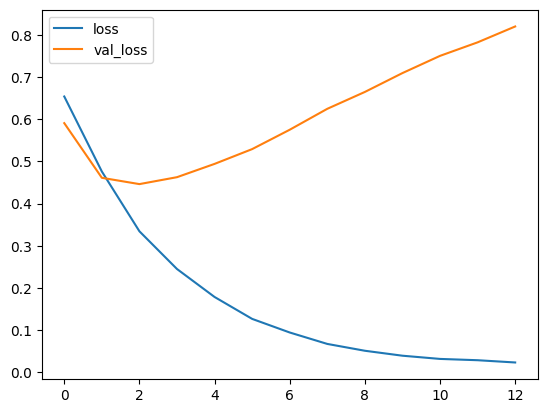

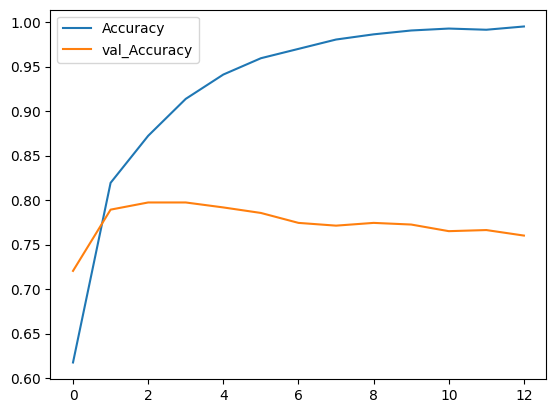

In [33]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]].plot()
pd.DataFrame(modelhistory.history)[["Accuracy","val_Accuracy"]].plot()
# pd.DataFrame(modelhistory.history)[["loss"]].plot()
# pd.DataFrame(modelhistory.history)[["Accuracy"]].plot()

<AxesSubplot:>

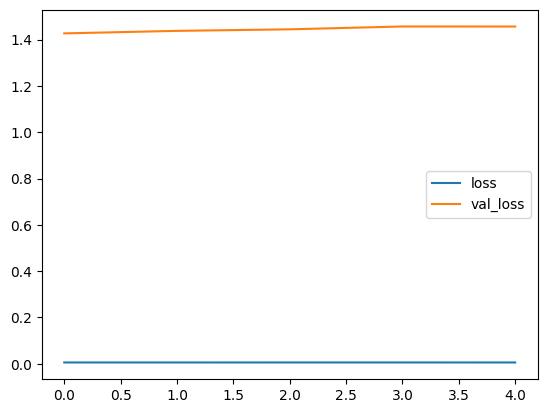

In [58]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]][:5].plot()

In [59]:
model.predict([data.text[7000:7001],keywords[7000:7001]])

1/1 [==============================] - 1s 1s/step


array([[0.99450314, 0.00549682]], dtype=float32)

In [60]:
data.text[7000:7001]

4694    Got it winning by a landslide those the perfec...
Name: text, dtype: object